In [1]:
import starfile
import mrcfile
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import ifftn
from scipy.ndimage import gaussian_filter
import os

In [2]:
meta_2d = starfile.open('20s_10025/Class2D/job006/run_it025_data.star')
meta_raw = starfile.open('20s_10025/Extract/job005/particles.star')
meta_3d_c1 = starfile.open('20s_10025/Class3D/job007/run_it025_data.star')
meta_3d_d7 = starfile.open('20s_10025/Class3D/job008/run_it025_data.star')
meta_3d_refine = starfile.open('20s_10025/Refine3D/job009/run_data.star')
meta_recenter = starfile.open('20s_10025/Extract/job010/particles.star')

In [3]:
image_idx = 20
imageName = meta_raw['rlnImageName'][image_idx]
print(imageName)
raw = meta_raw[meta_raw['rlnImageName'] == imageName][['rlnAngleRot', 'rlnAngleTilt','rlnAnglePsi']].iloc[0]
class_2d = meta_2d[meta_2d['rlnImageName'] == imageName][['rlnAngleRot', 'rlnAngleTilt','rlnAnglePsi', 'rlnClassNumber']].iloc[0]
c1 = meta_3d_c1[meta_3d_c1['rlnImageName'] == imageName][['rlnAngleRot', 'rlnAngleTilt','rlnAnglePsi', 'rlnOriginX', 'rlnOriginY']].iloc[0]
d7 = meta_3d_d7[meta_3d_d7['rlnImageName'] == imageName][['rlnAngleRot', 'rlnAngleTilt','rlnAnglePsi', 'rlnOriginX', 'rlnOriginY']].iloc[0]
refine = meta_3d_refine[meta_3d_refine['rlnImageName'] == imageName][['rlnAngleRot', 'rlnAngleTilt','rlnAnglePsi', 'rlnOriginX', 'rlnOriginY']].iloc[0]
recenter = meta_recenter[meta_raw['rlnImageName'] == imageName][['rlnAngleRot', 'rlnAngleTilt','rlnAnglePsi','rlnImageName']].iloc[0]

000021@Extract/job005/mrc/14sep05c_c_00007gr_00021sq_00017hl_00002es_c.mrcs


In [4]:
print(raw)
print(class_2d)
print(c1)
print(d7)
print(refine)
print(recenter)
print(recenter['rlnImageName'].split('@')[1])

rlnAngleRot      72.850158
rlnAngleTilt     82.944194
rlnAnglePsi    -176.085970
Name: 20, dtype: float64
rlnAngleRot       72.850158
rlnAngleTilt      82.944194
rlnAnglePsi       90.944964
rlnClassNumber    11.000000
Name: 49740, dtype: float64
rlnAngleRot     -29.105710
rlnAngleTilt     82.315163
rlnAnglePsi    -174.837530
rlnOriginX       -0.930150
rlnOriginY        3.069846
Name: 49740, dtype: float64
rlnAngleRot     100.785351
rlnAngleTilt     84.689252
rlnAnglePsi    -178.112340
rlnOriginX       -0.747900
rlnOriginY        3.252104
Name: 49740, dtype: float64
rlnAngleRot      98.131237
rlnAngleTilt     81.611015
rlnAnglePsi    -175.991170
rlnOriginX       -0.830220
rlnOriginY        3.862278
Name: 49740, dtype: float64
rlnAngleRot                                             98.131237
rlnAngleTilt                                            81.611015
rlnAnglePsi                                            -175.99117
rlnImageName    000021@Extract/job010/mrc/14sep05c_c_00007gr_0...
N

In [5]:
def relion_projection(map, output,rot,tilt,psi, xoff, yoff):
    os.system(f'relion_project --i {map} --o {output} --rot {rot} --tilt {tilt} --psi {psi} --xoff {xoff}, --yoff {yoff}')
def relion_lowpass(img, output, lp):
    os.system(f'relion_image_handler --i {img} --o {output} --lowpass {lp}')

In [6]:
relion_lowpass(f'20s_10025/{imageName.split("@")[1]}', 'lowpass.mrcs', 20)
relion_projection('20s_10025/Class3D/job007/run_it025_class001.mrc', 'projc1.mrc', c1['rlnAngleRot'], c1['rlnAngleTilt'], c1['rlnAnglePsi'], c1['rlnOriginX'], c1['rlnOriginY'])
relion_projection('20s_10025/Class3D/job008/run_it025_class001.mrc', 'projd7.mrc', d7['rlnAngleRot'], d7['rlnAngleTilt'], d7['rlnAnglePsi'], d7['rlnOriginX'], d7['rlnOriginY'])
relion_projection('20s_10025/Refine3D/job009/run_class001.mrc', 'projRefine.mrc', refine['rlnAngleRot'], refine['rlnAngleTilt'], refine['rlnAnglePsi'], refine['rlnOriginX'], refine['rlnOriginY'])
relion_lowpass(f'20s_10025/{recenter["rlnImageName"].split("@")[1]}', 'lowpass_recenter.mrcs', 20)

   0/   0 sec ..~~(,_,">

   3/   3 sec ............................................................~~(,_,">
 Reading map: 20s_10025/Class3D/job007/run_it025_class001.mrc


         The value in the input image header (= 1.32) is used instead.


 Done reading map!
 Done writing projc1.mrc
 Reading map: 20s_10025/Class3D/job008/run_it025_class001.mrc
 Done reading map!


         The value in the input image header (= 1.32) is used instead.


 Done writing projd7.mrc
 Reading map: 20s_10025/Refine3D/job009/run_class001.mrc
 Done reading map!


         The value in the input image header (= 1.32) is used instead.


 Done writing projRefine.mrc
   0/   0 sec .~~(,_,">

   2/   2 sec ............................................................~~(,_,">


In [7]:
particle_idx = int(imageName.split("@")[0]) -1
class_number = int(class_2d['rlnClassNumber'])-1
with mrcfile.open(f'20s_10025/{imageName.split("@")[1]}') as mrc:
    mrc_stack = mrc.data[particle_idx]
    mrc_stack_gs = gaussian_filter( mrc_stack, sigma=5)
with mrcfile.open(f'lowpass.mrcs') as mrc:
    mrc_stack_lp = mrc.data[particle_idx]
with mrcfile.open('20s_10025/Class2D/job006/run_it025_classes.mrcs') as mrc:
    mrc_class = mrc.data[class_number]
with mrcfile.open('projc1.mrc') as mrc:
    mrc_projc1 = mrc.data
with mrcfile.open('projd7.mrc') as mrc:
    mrc_projd7 = mrc.data
with mrcfile.open('projRefine.mrc') as mrc:
    mrc_projRefine = mrc.data
with mrcfile.open(f'20s_10025/{recenter["rlnImageName"].split("@")[1]}') as mrc:
    mrc_stack_recenter = mrc.data[particle_idx]
    mrc_stack_recenter_gs = gaussian_filter(mrc_stack_recenter, sigma=5)
with mrcfile.open(f'lowpass_recenter.mrcs') as mrc:
    mrc_stack_recenter_lp = mrc.data[particle_idx]

000021@Extract/job005/mrc/14sep05c_c_00007gr_00021sq_00017hl_00002es_c.mrcs


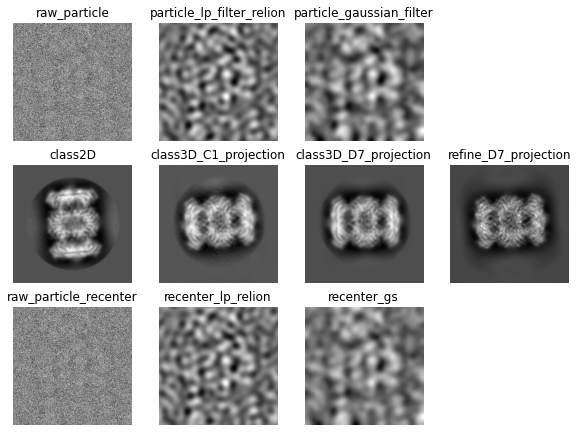

In [8]:
print(imageName)
plt.figure(figsize=(10,10))
ax1 = plt.subplot(4,4,1)
ax1.set_title('raw_particle')
plt.imshow(mrc_stack, cmap='gray')
ax1.axis('off')

ax2 = plt.subplot(4,4,2)
ax2.set_title('particle_lp_filter_relion')
plt.imshow(mrc_stack_lp, cmap='gray')
ax2.axis('off')

ax3 = plt.subplot(4,4,3)
ax3.set_title('particle_gaussian_filter')
plt.imshow(mrc_stack_gs, cmap='gray')
ax3.axis('off')

ax4 = plt.subplot(4,4,5)
ax4.set_title('class2D')
plt.imshow(mrc_class, cmap='gray')
ax4.axis('off')

ax5 = plt.subplot(4,4,6)
ax5.set_title('class3D_C1_projection')
plt.imshow(mrc_projc1, cmap='gray')
ax5.axis('off')

ax6 = plt.subplot(4,4,7)
ax6.set_title('class3D_D7_projection')
plt.imshow(mrc_projd7, cmap='gray')
ax6.axis('off')

ax7 = plt.subplot(4,4,8)
ax7.set_title('refine_D7_projection')
plt.imshow(mrc_projRefine, cmap='gray')
ax7.axis('off')

ax8 = plt.subplot(4,4,9)
ax8.set_title('raw_particle_recenter')
plt.imshow(mrc_stack_recenter, cmap='gray')
ax8.axis('off')

ax9 = plt.subplot(4,4,10)
ax9.set_title('recenter_lp_relion')
plt.imshow(mrc_stack_recenter_lp, cmap='gray')
ax9.axis('off')

ax10 = plt.subplot(4,4,11)
ax10.set_title('recenter_gs')
plt.imshow(mrc_stack_recenter_gs, cmap='gray')
ax10.axis('off')

plt.savefig(f'{image_idx}.png')


In [9]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

In [10]:
import pixellib
from pixellib.semantic import semantic_segmentation

segment_image = semantic_segmentation()

2021-10-11 09:50:29.946645: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-10-11 09:50:30.873295: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-11 09:50:30.875690: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-11 09:50:31.058152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-11 09:50:31.058552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeFo

In [11]:
segment_image.load_pascalvoc_model()

TypeError: load_pascalvoc_model() missing 1 required positional argument: 'model_path'

In [12]:
from skimage import data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

import numpy as np


(<Figure size 1008x1008 with 1 Axes>, <AxesSubplot:>)

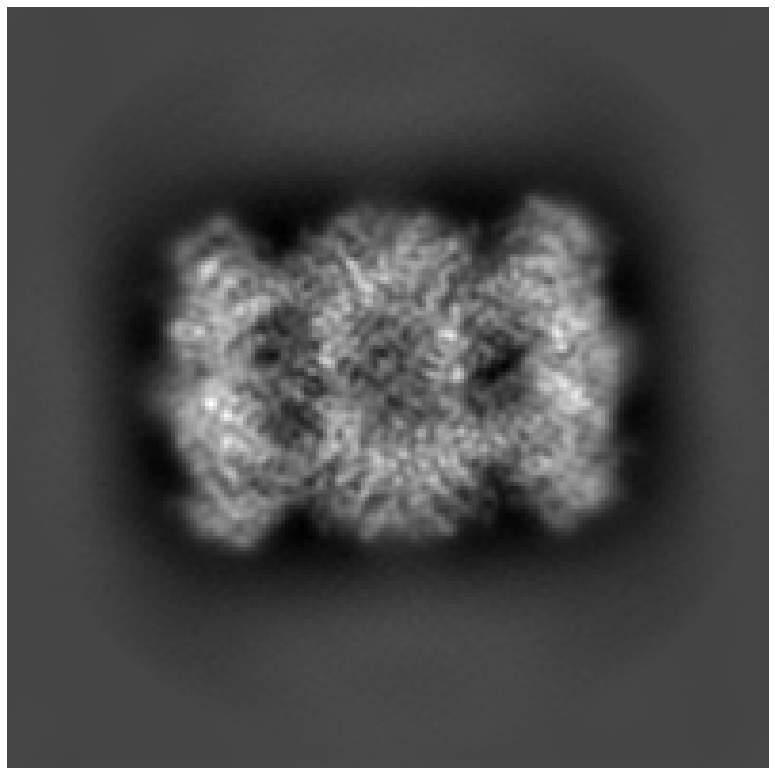

In [13]:
image_show(mrc_projRefine)

In [14]:
with mrcfile.open('projRefine.mrc') as mrc:
    mrc_projRefine = mrc.data
plt.imsave('mrc_projRefine.png',mrc_projRefine, cmap='gray')
mrc_projRefine.setflags(write=1)
mrc_projRefine[mrc_projRefine < 0.05] = 0
mrc_projRefine[mrc_projRefine > 0.05] = 1

(0.0, 1.0)

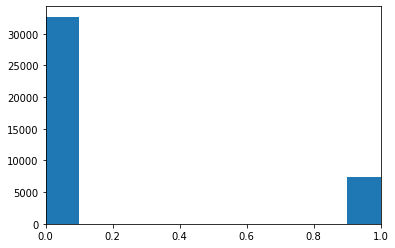

In [15]:
fig, ax = plt.subplots(1,1)
ax.hist(mrc_projRefine.ravel(), range=(mrc_projRefine.min(),mrc_projRefine.max()))
ax.set_xlim(mrc_projRefine.min(),mrc_projRefine.max())

(<Figure size 1008x1008 with 1 Axes>, <AxesSubplot:>)

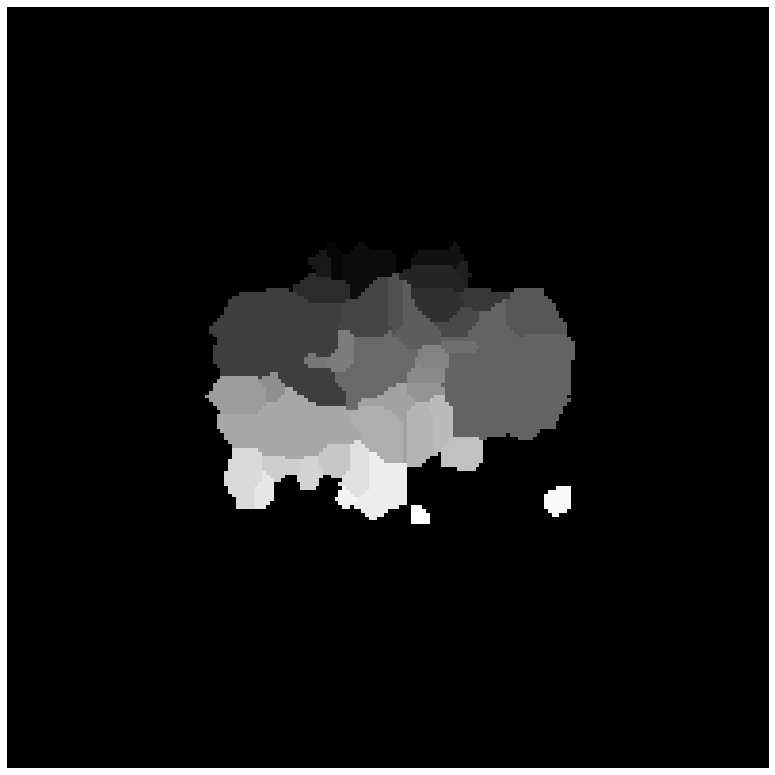

In [16]:
proj_seg = seg.watershed(mrc_projRefine)

image_show(proj_seg)